In [1]:
import optuna

# Torch
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import DataLoader, HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU

from torch_geometric.nn import SAGEConv, DenseSAGEConv, GATConv, HeteroConv, Linear, GATv2Conv, TransformerConv
from torch_geometric.nn import aggr

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss

# Misc
import os, sys
import time
from math import ceil
import random
from IPython.display import clear_output
from termcolor import colored

# CS2
sys.path.append(os.path.abspath('../../package'))
from CS2.visualize import HeteroGNNRoundAnalyzer

# Torch and CUDA options
torch.manual_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_TEMP_GRAPH_DATA = '../../data/matches-processed/cs2/temporal-hetero-graph/'
PATH_MODELS = '../../model/tgn/'
BATCH_SIZE = 100

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Data Loaders

In [2]:
class CSTemporalDataLoader(DataLoader):

    def __init__(self, dataset, batch_size=1, shuffle=False, *args, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, *args, **kwargs)

        self._dataset = dataset
        self._batch_size = batch_size
        self._shuffle = shuffle

    def __iter__(self):
        # Optionally shuffle the dataset
        indices = list(range(len(self._dataset)))
        if self._shuffle:
            torch.random.manual_seed(42)  # Ensure reproducibility if needed
            indices = torch.randperm(len(self._dataset)).tolist()

        # Yield batches of DTDGs
        batch = []
        for idx in indices:
            batch.append(self._dataset[idx])
            if len(batch) == self._batch_size:
                yield batch
                batch = []

        # Yield the last smaller batch if it exists
        if batch:
            yield batch


### Training data

In [3]:
train_data = torch.load(PATH_TEMP_GRAPH_DATA + 'train.pt', weights_only=False)
train_data = [temporal_graph for temporal_graph in train_data if len(temporal_graph) == 20]
random.shuffle(train_data)
print('Train data length:', len(train_data))

train_loader = CSTemporalDataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

Train data length: 66547


In [82]:
for batch in train_loader:
    flattened_list = [hetero_graph for temporal_graph in batch for hetero_graph in temporal_graph]
    print('Batch length:', len(batch))
    print('Flattened batch length:', len(flattened_list))

    dl = DataLoader(flattened_list, batch_size=1000, shuffle=False)
    # for data in dl:
    #     print(data)
    break

Batch length: 50
Flattened batch length: 1000


In [108]:
train_loader = CSTemporalDataLoader(train_data[:5000], batch_size=BATCH_SIZE, shuffle=True)

### Validation data

In [5]:
val_data = torch.load(PATH_TEMP_GRAPH_DATA + 'val.pt', weights_only=False)
val_data = [temporal_graph for temporal_graph in val_data if len(temporal_graph) == 20]
random.shuffle(val_data)

print('Validation data length:', len(val_data))
val_loader = CSTemporalDataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Validation data length: 21202


In [109]:
val_loader = CSTemporalDataLoader(val_data[:1500], batch_size=BATCH_SIZE, shuffle=True)

----
## Temporal Heterogeneous GNN

### Model

In [2]:
temporal_hetero_gnn_class = """
class TemporalHeterogeneousGNN(torch.nn.Module):


    def __init__(self, player_dims, map_dims, dense_layers, player_attention_heads=None, map_attention_heads=None, player_K=1, map_K=1):

        super().__init__()

        if player_attention_heads is not None and len(player_dims) != len(player_attention_heads):
            raise ValueError('The length of player dimensions and player attention heads arrays must be the same.')
        if map_attention_heads is not None and len(map_dims) != len(map_attention_heads):
            raise ValueError('The length of map dimensions and map attention heads arrays must be the same.')

        self.map_convs = len(map_dims)
        self.player_convs = len(player_dims)
        self.conv_layer_number = max([self.map_convs, self.player_convs])

        
        # Create convolutional layers
        self.convs = torch.nn.ModuleList()
        for conv_idx in range(self.conv_layer_number + 1):

            layer_config = {}

            if conv_idx < len(player_dims):
            
                if player_attention_heads is None:
                    layer_config[('player', 'is', 'player')] = GATv2Conv((-1, -1), player_dims[conv_idx], add_self_loops=False)
                else:
                    layer_config[('player', 'is', 'player')] = GATv2Conv((-1, -1), player_dims[conv_idx], add_self_loops=False, heads=player_attention_heads[conv_idx])

            if conv_idx < len(player_dims):
            
                if player_attention_heads is None:
                    layer_config[('player', 'closest_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False)
                else:
                    layer_config[('player', 'closest_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False, heads=map_attention_heads[conv_idx])

                
            if conv_idx < len(map_dims):

                if map_attention_heads is None:
                    layer_config[('map', 'connected_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False)
                else:
                    layer_config[('map', 'connected_to', 'map')] = GATv2Conv((-1, -1), map_dims[conv_idx], add_self_loops=False, heads=map_attention_heads[conv_idx])
                
            conv = HeteroConv(layer_config, aggr='mean')
            self.convs.append(conv)

            
        # Temporal layers for player and map nodes
        self.player_temporal_layer = GConvGRU(in_channels=player_dims[-1], out_channels=player_dims[-1], K=player_K)
        self.map_temporal_layer = GConvGRU(in_channels=map_dims[-1], out_channels=map_dims[-1], K=map_K)



        # Create linear layer for the flattened input
        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])

        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []

        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        






    
    

    def forward(self, batch, batch_size, temporal_batch_size):

        # --------------------------------------------
        #        Spatial convolution preparation
        # --------------------------------------------

        # Get the data from the batch and prepare for spatial convolutions
        spatial_conv_list = [hetero_graph for temporal_graph in batch for hetero_graph in temporal_graph]
        spatial_conv_loader = DataLoader(spatial_conv_list, batch_size=len(spatial_conv_list), shuffle=False)
        spatial_conv_data = next(iter(spatial_conv_loader)).to('cuda')

        # --------------------------------------------
        #             Spatial convolutions
        # --------------------------------------------

        conv_idx = 0
        for conv in self.convs:
        
            temp = conv(spatial_conv_data.x_dict, spatial_conv_data.edge_index_dict)

            if conv_idx < self.player_convs:
                spatial_conv_data['player'].x = F.leaky_relu(temp['player'])

            if conv_idx < self.map_convs:
                spatial_conv_data['map'].x = F.leaky_relu(temp['map'])

            conv_idx += 1

        
            

        # --------------------------------------------
        #       Temporal convolution preparation
        # --------------------------------------------

        # Container for the flattened graphs after the convolutions
        T_graphs = {}

        # Collect the graphs from the batch
        for graph_idx in range(batch_size * temporal_batch_size):

            # Get the actual graph
            actual_x_dict, actual_edge_index_dict = self.get_actual_graph(spatial_conv_data.x_dict, spatial_conv_data.edge_index_dict, graph_idx, batch_size * temporal_batch_size)

            # Get the graph data
            graph_data = {
                'round': spatial_conv_data.y['round'][graph_idx],
                'time': spatial_conv_data.y['time'][graph_idx],
                'remaining_time': spatial_conv_data.y['remaining_time'][graph_idx],
                'CT_alive_num': spatial_conv_data.y['CT_alive_num'][graph_idx],
                'T_alive_num': spatial_conv_data.y['T_alive_num'][graph_idx],
                'CT_total_hp': spatial_conv_data.y['CT_total_hp'][graph_idx],
                'T_total_hp': spatial_conv_data.y['T_total_hp'][graph_idx],
                'CT_equipment_value': spatial_conv_data.y['CT_equipment_value'][graph_idx],
                'T_equipment_value': spatial_conv_data.y['T_equipment_value'][graph_idx],
                'CT_losing_streak': spatial_conv_data.y['CT_losing_streak'][graph_idx],
                'T_losing_streak': spatial_conv_data.y['T_losing_streak'][graph_idx],
                'is_bomb_dropped': spatial_conv_data.y['is_bomb_dropped'][graph_idx],
                'is_bomb_being_planted': spatial_conv_data.y['is_bomb_being_planted'][graph_idx],
                'is_bomb_being_defused': spatial_conv_data.y['is_bomb_being_defused'][graph_idx],
                'is_bomb_planted_at_A_site': spatial_conv_data.y['is_bomb_planted_at_A_site'][graph_idx],
                'is_bomb_planted_at_B_site': spatial_conv_data.y['is_bomb_planted_at_B_site'][graph_idx],
                'bomb_X': spatial_conv_data.y['bomb_X'][graph_idx],
                'bomb_Y': spatial_conv_data.y['bomb_Y'][graph_idx],
                'bomb_Z': spatial_conv_data.y['bomb_Z'][graph_idx],
                'bomb_mx_pos1': spatial_conv_data.y['bomb_mx_pos1'][graph_idx],
                'bomb_mx_pos2': spatial_conv_data.y['bomb_mx_pos2'][graph_idx],
                'bomb_mx_pos3': spatial_conv_data.y['bomb_mx_pos3'][graph_idx],
                'bomb_mx_pos4': spatial_conv_data.y['bomb_mx_pos4'][graph_idx],
                'bomb_mx_pos5': spatial_conv_data.y['bomb_mx_pos5'][graph_idx],
                'bomb_mx_pos6': spatial_conv_data.y['bomb_mx_pos6'][graph_idx],
                'bomb_mx_pos7': spatial_conv_data.y['bomb_mx_pos7'][graph_idx],
                'bomb_mx_pos8': spatial_conv_data.y['bomb_mx_pos8'][graph_idx],
                'bomb_mx_pos9': spatial_conv_data.y['bomb_mx_pos9'][graph_idx],
            }

            # Get the time index and create a key for it in the T container
            time_index = (graph_idx % temporal_batch_size)
            if time_index not in T_graphs:
                T_graphs[time_index] = []

            # Reconstruct the graph data
            recunstructed_graph = HeteroData()

            # Reconstruct the node features (x)
            for node_type, x in actual_x_dict.items():
                recunstructed_graph[node_type].x = x

            # Reconstruct the edge indices (edge_index)
            for edge_type, edge_index in actual_edge_index_dict.items():
                recunstructed_graph[edge_type].edge_index = edge_index

            # Reconstruct the y values (y)
            for y_key, y_value in graph_data.items():
                recunstructed_graph['y'][y_key] = y_value

            T_graphs[time_index].append(recunstructed_graph)

        # --------------------------------------------------
        #               Temporal convolutions
        # --------------------------------------------------

        for time_idx in range(temporal_batch_size):

            # Get the data for the current time index
            time_idx_list = T_graphs[time_idx]
            time_idx_data_loader = DataLoader(time_idx_list, batch_size=len(time_idx_list), shuffle=False)
            time_idx_data = next(iter(time_idx_data_loader))

            # Temporal convolutions
            time_idx_data['player'].x = F.leaky_relu(self.player_temporal_layer(time_idx_data.x_dict['player'], time_idx_data.edge_index_dict[('player', 'is', 'player')]))
            time_idx_data['map'].x = F.leaky_relu(self.map_temporal_layer(time_idx_data.x_dict['map'], time_idx_data.edge_index_dict[('map', 'connected_to', 'map')]))

            # Update the T_graphs container
            T_graphs[time_idx] = time_idx_data

            


            

        # --------------------------------------------------
        #               Dense layer preparation
        # --------------------------------------------------

        # Reconstruct the original batch ordering
        flattened_graphs = []

        for graph_idx in range(batch_size):
            for time_idx in range(temporal_batch_size):

                actual_x_dict, actual_edge_index_dict = self.get_actual_graph(T_graphs[time_idx].x_dict, T_graphs[time_idx].edge_index_dict, graph_idx, batch_size)

                graph_data = torch.tensor([
                    T_graphs[time_idx]['y']['round'][graph_idx],
                    T_graphs[time_idx]['y']['time'][graph_idx],
                    T_graphs[time_idx]['y']['remaining_time'][graph_idx],
                    T_graphs[time_idx]['y']['CT_alive_num'][graph_idx],
                    T_graphs[time_idx]['y']['T_alive_num'][graph_idx],
                    T_graphs[time_idx]['y']['CT_total_hp'][graph_idx],
                    T_graphs[time_idx]['y']['T_total_hp'][graph_idx],
                    T_graphs[time_idx]['y']['CT_equipment_value'][graph_idx],
                    T_graphs[time_idx]['y']['T_equipment_value'][graph_idx],
                    T_graphs[time_idx]['y']['CT_losing_streak'][graph_idx],
                    T_graphs[time_idx]['y']['T_losing_streak'][graph_idx],
                    T_graphs[time_idx]['y']['is_bomb_dropped'][graph_idx],
                    T_graphs[time_idx]['y']['is_bomb_being_planted'][graph_idx],
                    T_graphs[time_idx]['y']['is_bomb_being_defused'][graph_idx],
                    T_graphs[time_idx]['y']['is_bomb_planted_at_A_site'][graph_idx],
                    T_graphs[time_idx]['y']['is_bomb_planted_at_B_site'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_X'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_Y'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_Z'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos1'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos2'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos3'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos4'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos5'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos6'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos7'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos8'][graph_idx],
                    T_graphs[time_idx]['y']['bomb_mx_pos9'][graph_idx],
                ]).to('cuda')
                
                x = torch.cat([torch.flatten(actual_x_dict['player']), torch.flatten(actual_x_dict['map']), torch.flatten(graph_data)])
                flattened_graphs.append(x)

                
        # Stack the flattened graphs
        x = torch.stack(flattened_graphs).to('cuda')
        
        # --------------------------------------------------
        #                   Dense layers
        # --------------------------------------------------

        x = self.linear(x)
        x = F.leaky_relu(x)
        x = self.dense(x)
        
        return x
    






    # --------------------------------------------------
    # Helper functions
    # --------------------------------------------------

    def get_actual_graph(self, x_dict, edge_index_dict, graph_idx, batch_size):

        # Node feature dictionary for the actual graph
        actual_x_dict = {}

        SINGLE_PLAYER_NODE_SIZE = int(x_dict['player'].shape[0] / batch_size)
        SINGLE_MAP_NODE_SIZE = int(x_dict['map'].shape[0] / batch_size)

        actual_x_dict['player'] = x_dict['player'][graph_idx * SINGLE_PLAYER_NODE_SIZE: (graph_idx + 1) * SINGLE_PLAYER_NODE_SIZE, :]
        actual_x_dict['map'] = x_dict['map'][graph_idx * SINGLE_MAP_NODE_SIZE: (graph_idx + 1) * SINGLE_MAP_NODE_SIZE, :]


        

        # Edge index dictionary for the actual graph
        actual_edge_index_dict = {}

        SINGLE_PLAYER_TO_PLAYER_EDGE_SIZE = int(edge_index_dict[('player', 'is', 'player')].shape[1] / batch_size)
        SINGLE_PLAYER_TO_MAP_EDGE_SIZE = int(edge_index_dict[('player', 'closest_to', 'map')].shape[1] / batch_size)
        SINGLE_MAP_TO_MAP_EDGE_SIZE = int(edge_index_dict[('map', 'connected_to', 'map')].shape[1] / batch_size)

        actual_edge_index_dict[('map', 'connected_to', 'map')] = edge_index_dict[('map', 'connected_to', 'map')] \
            [:, graph_idx  *SINGLE_MAP_TO_MAP_EDGE_SIZE: (graph_idx + 1) * SINGLE_MAP_TO_MAP_EDGE_SIZE] - graph_idx * SINGLE_MAP_NODE_SIZE
        
        actual_edge_index_dict[('player', 'closest_to', 'map')] = edge_index_dict[('player', 'closest_to', 'map')] \
            [:, graph_idx * SINGLE_PLAYER_TO_MAP_EDGE_SIZE: (graph_idx + 1) * SINGLE_PLAYER_TO_MAP_EDGE_SIZE]
        
        player_to_map_correction_tensor = torch.tensor([SINGLE_PLAYER_NODE_SIZE * graph_idx, SINGLE_MAP_NODE_SIZE * graph_idx]).to('cuda')
        actual_edge_index_dict[('player', 'closest_to', 'map')] = actual_edge_index_dict[('player', 'closest_to', 'map')] - player_to_map_correction_tensor.view(-1, 1)
        
        actual_edge_index_dict[('player', 'is', 'player')] = edge_index_dict[('player', 'is', 'player')] \
            [:, graph_idx * SINGLE_PLAYER_TO_PLAYER_EDGE_SIZE: (graph_idx + 1) * SINGLE_PLAYER_TO_PLAYER_EDGE_SIZE]
        
        player_is_player_correction_tensor = torch.tensor([SINGLE_PLAYER_NODE_SIZE * graph_idx, SINGLE_PLAYER_NODE_SIZE * graph_idx]).to('cuda')
        actual_edge_index_dict[('player', 'is', 'player')] = actual_edge_index_dict[('player', 'is', 'player')] - player_is_player_correction_tensor.view(-1, 1)

        
        return actual_x_dict, actual_edge_index_dict
    
"""

exec(temporal_hetero_gnn_class)

### Training functions

In [111]:
def train(model, optimizer, loss_function, train_loader, val_loader, epochs, trainable_params, save_path, return_val_loss=False):

    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    accuracies = []
    brier_scores = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(1, epochs + 1):

        epoch_start = time.time()
        model.train()

        total_loss = 0

        for data in train_loader:  # Iterate in batches over the training dataset.

            optimizer.zero_grad()  # Clear gradients.
            
            out = model(data, len(data), len(data[0])).float()  # Perform a single forward pass.
            targets = []
            for temporal_graph in data:
                for graph in temporal_graph:
                    targets.append(graph.y['CT_wins'])
            target = torch.tensor(targets).float().to('cuda')

            loss = loss_function(out.squeeze(), target.squeeze())  # Compute the loss.
            loss.backward()  # Backpropagate.
            optimizer.step()  # Update model parameters.

            total_loss += loss.item()  # Accumulate the loss.


        # Calculate train and validation metrics
        train_avg_loss = total_loss / len(train_loader)
        val_avg_loss, val_accuracy, val_brier_score, val_precision, val_recall, val_f1, val_conf_mx, val_fpr, val_tpr, val_sorted_predictions = validation(model, loss_function, val_loader) 

        # Epoch information
        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start
        epoch_end_time = time.asctime(time.localtime()) 

        # Save metrics
        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        accuracies.append(val_accuracy)
        brier_scores.append(val_brier_score)
        precisions.append(val_precision)
        recalls.append(val_recall)
        f1_scores.append(val_f1)


        # Save model
        torch.save(model, PATH_MODELS + save_path + f'epoch_{epoch}.pt')

        # Visualize epoch
        epoch_result_visualization(
            epochs, 
            epoch,
            epoch_end_time,
            epoch_duration,

            train_losses, 
            val_losses, 
            accuracies,
            brier_scores,
            precisions, 
            recalls, 
            f1_scores,
            val_conf_mx,
            val_fpr, val_tpr,
            val_sorted_predictions,

            trainable_params,
            save_path
        )
    
    if return_val_loss:
        return val_losses

        

def validation(model, loss_function, val_loader):
    
    # Switch to evaluation mode.
    model.eval()

    total_loss = 0

    predictions_all = []
    targets_all = []

    with torch.no_grad():
        
        for data in val_loader:  # Iterate in batches over the validation dataset.
            
            out = model(data, len(data), len(data[0])).float()  # Perform a single forward pass.
            targets = []
            for temporal_graph in data:
                for graph in temporal_graph:
                    targets.append(graph.y['CT_wins'])
            target = torch.tensor(targets).float().to('cuda')

            loss = loss_function(out.squeeze(), target.squeeze())
            total_loss += loss.item()

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Prediction formattings
    predictions_all = np.array(predictions_all).flatten().tolist()
    sorted_predictions = np.sort(predictions_all).tolist()
    rounded_predictions = np.round(predictions_all)

    # Calculate metrics
    val_avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    brier_score = brier_score_loss(targets_all, predictions_all)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    return val_avg_loss, accuracy, brier_score, precision, recall, f1, cm, fpr, tpr, sorted_predictions



def epoch_result_visualization(
    epochs,
    epoch,
    epoch_end_time,
    epoch_duration,

    train_losses,
    val_losses,
    accuracies, 
    brier_scores,
    precisions, 
    recalls, 
    f1_scores,
    conf_mx,
    fpr, tpr,
    sorted_predictions,

    trainable_params,
    save_path
):
    # Clear the output
    clear_output(wait=True)

    # Print the results
    print_epoch_results(epoch, epoch_end_time, epoch_duration, train_losses[-1], val_losses[-1], accuracies[-1], brier_scores[-1], precisions[-1], recalls[-1], f1_scores[-1], tpr, fpr, trainable_params, save_path)
    
    
    # Visualize the confusion matrix, ROC/AUC curve and model calibration plot
    visualize_CM_ROCAUC_CAL(conf_mx, fpr, tpr, sorted_predictions, save_path, epoch)


    # Visualize the training and validation loss
    visualize_train_val_metrics(epochs, epoch, train_losses, val_losses, accuracies, brier_scores, precisions, recalls, f1_scores, save_path)

def print_epoch_results(epoch, epoch_end_time, epoch_duration, train_avg_loss, val_avg_loss, accuracy, brier_score, precision, recall, f1, tpr, fpr, trainable_params, save_path):

    print('Trainable parameters: ' + str(trainable_params))
    print("-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n" + 
          colored('Time: \n', "light_blue", attrs=["bold"]) +
         f"   -End time: {epoch_end_time} \n"
         f"   -Duration: {epoch_duration}sec ({epoch_duration / 60} min) \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n" +
          colored('Training results: \n', "light_blue", attrs=["bold"]) +
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n" +
          colored('Validation results: \n', "light_blue", attrs=["bold"]) +
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Brier score: {brier_score} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
         f"   - AUC: {auc(fpr, tpr)} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")
    
    with open(PATH_MODELS + save_path + f'epoch_{epoch}_metrics.txt', 'w') as file:
        file.write(
          "Trainable parameters: " + str(trainable_params) + "\n"
          "-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n"
          "Time: \n"
         f"   -End time: {epoch_end_time}s \n"
         f"   -Duration: {epoch_duration}s \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Training results:\n"
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Validation results: \n"
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Brier score: {brier_score} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
         f"   - AUC: {auc(fpr, tpr)} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

def visualize_CM_ROCAUC_CAL(cm, fpr, tpr, sorted_predictions, save_path, epoch):

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'Epoch {epoch} - Validation scores', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.3f' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate', fontsize=8)
    axs[1].set_ylabel('True Positive Rate', fontsize=8)
    axs[1].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_aspect('equal')

    # Model calibration plot
    axs[2].plot(np.linspace(1, len(sorted_predictions), len(sorted_predictions)), sorted_predictions, lw=2)
    axs[2].set_ylim([0.0, 1.0])
    axs[2].plot([0, len(sorted_predictions)], [0, 1], color='black', lw=1, linestyle='--')
    axs[2].set_xlabel('Samples', fontsize=8)
    axs[2].set_ylabel('Predicted Proba', fontsize=8)
    axs[2].set_title('Calibration curve', fontsize=10, y=1)
    axs[2].set_aspect('auto')

    plt.tight_layout()
    plt.savefig(PATH_MODELS + save_path + f'epoch_{epoch}_val_conf_AUC_cal.png')
    plt.show()

def visualize_train_val_metrics(epochs, epoch, train_losses, val_losses, accuracies, brier_scores, precisions, recalls, f1_scores, save_path):

    # ----------------------------------------
    # Metrics visualization
    # ----------------------------------------

    fig, axs = plt.subplots(2, 4, figsize=(11, 4.5))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=12)

    epochs_range = np.arange(1, epoch + 1)

    def plot_metric(ax, data, title, ylabel, color):
        if len(data) == 1:
            ax.scatter(epochs_range, data, s=10, c=color)
        else:
            ax.plot(epochs_range, data, marker='o', linestyle='-', color=color)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel(ylabel, fontsize=8)
        ax.set_xticks(epochs_range)
        ax.set_xlim(-1, epochs)
        if 'Loss' not in title:
            ax.set_ylim(0, 1)
        ax.grid(True)

    plot_metric(axs[0, 0], train_losses, 'Train Loss', 'Loss', 'cornflowerblue')
    plot_metric(axs[0, 1], val_losses, 'Validation Loss', 'Loss', 'darkorange')
    plot_metric(axs[0, 2], accuracies, 'Accuracy', 'Accuracy', 'limegreen')
    plot_metric(axs[0, 3], brier_scores, 'Brier score', 'Brier score', 'slateblue')
    plot_metric(axs[1, 0], precisions, 'Precision', 'Precision', 'red')
    plot_metric(axs[1, 1], recalls, 'Recall', 'Recall', 'teal')
    plot_metric(axs[1, 2], f1_scores, 'F1 Score', 'F1 Score', 'black')

    plt.tight_layout()
    plt.savefig(PATH_MODELS + save_path + f'epoch_{epoch}_val_metrics.png')
    plt.show()



# TODO: rewrite according to updated train and validation functions
def test(model, loss_function, test_loader, batch_size):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in test_loader:  # Iterate in batches over the test dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')

            loss = loss_function(out.squeeze(), target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    rounded_predictions = np.round(predictions_all)
    
    sorted_predictions = [pred[0] for pred in predictions_all]
    sorted_predictions = np.sort(sorted_predictions)

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    print("-------------------------------------------------------------------------------------------\n"
          "                                      Test Results\n"                                     
          "-------------------------------------------------------------------------------------------\n"
         f"Average loss: {avg_loss} \n"
         f"Accuracy: {accuracy} \n"
         f"Precision: {precision} \n"
         f"Recall: {recall} \n"
         f"F1: {f1} \n"
          "Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

    # ----------------------------------------
    # Confusion matrix & ROC/AUC visualization
    # ----------------------------------------

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle('Test results', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate', fontsize=8)
    axs[1].set_ylabel('True Positive Rate', fontsize=8)
    axs[1].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_aspect('equal')

    # Model calibration plot
    axs[2].plot(np.linspace(1, len(sorted_predictions), len(sorted_predictions)), sorted_predictions, lw=2)
    axs[2].set_ylim([0.0, 1.0])
    axs[2].plot([0, len(sorted_predictions)], [0, 1], color='black', lw=1, linestyle='--')
    axs[2].set_xlabel('Samples', fontsize=8)
    axs[2].set_ylabel('Predicted Proba', fontsize=8)
    axs[2].set_title('Calibration curve', fontsize=10, y=1)
    axs[2].set_aspect('auto')



    plt.tight_layout()
    plt.show()

### Model Training

#### Hyperparam search

Trainable parameters: 50933
-------------------------------------------------------------------------------------------
                                     Epoch 1
-------------------------------------------------------------------------------------------
Time: 
   -End time: Sun Oct 20 15:08:22 2024 
   -Duration: 869.604923248291sec (14.493415387471517 min) 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results: 
   - Average loss: 0.7709 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 0.6951578962802887 
   - Accuracy: 0.4672 
   - Brier score: 0.25100510840336293 
   - Precision: 0.4672 
   - Recall: 1.0 
   - F1: 0.6368593238822247 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



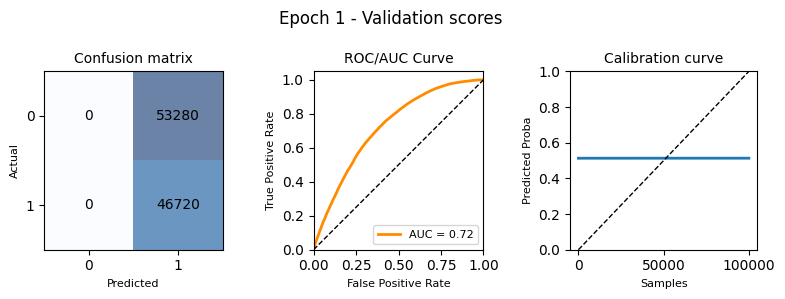

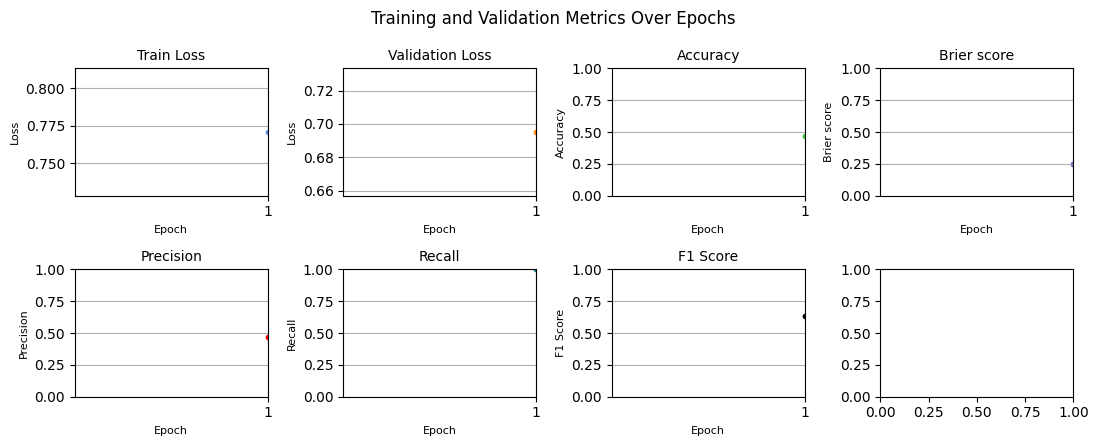

[I 2024-10-20 15:08:25,243] Trial 9 finished with value: 0.6951578962802887 and parameters: {'learning_rate': 9.675851047746367e-05, 'weight_decay': 0.048614165680094065}. Best is trial 2 with value: 0.6714992713928223.
[W 2024-10-20 15:13:44,551] Trial 10 failed with parameters: {'learning_rate': 0.05831348887004076, 'weight_decay': 0.07957726235516235} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\szmid\AppData\Local\Temp\ipykernel_1616\2921495205.py", line 68, in objective
    val_loss = train(
               ^^^^^^
  File "C:\Users\szmid\AppData\Local\Temp\ipykernel_1616\2878687242.py", line 24, in train
    out = model(data, len(data), len(data[0])).float()  # 

KeyboardInterrupt: 

In [13]:
# Save results
save_path = '241020_opt/'
if not os.path.exists(PATH_MODELS + save_path):
    os.mkdir(PATH_MODELS + save_path)

def objective(trial):
    # Hyperparameter tuning with optuna
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)

    # GNN configuration
    dense_layers = [
        {
            "dropout": 0,
            "num_of_layers": 1,
            "neuron_num": 24,
            "input_neuron_num": 48,
            "activation_function": torch.nn.LeakyReLU()
        },
        {
            "dropout": 0.5,
        },
        {
            "dropout": 0,
            "num_of_layers": 2,
            "neuron_num": 8,
            "input_neuron_num": 24,
            "activation_function": torch.nn.LeakyReLU()
        },
        {
            "dropout": 0.5,
        },
        {
            "dropout": 0,
            "num_of_layers": 1,
            "neuron_num": 1,
            "input_neuron_num": 8,
            "activation_function": None
        },
    ]
    player_dims = [30, 5]
    map_dims = [15, 10, 3]
    player_attention_heads = None
    map_attention_heads = None

    # GNN and training initialization
    model = TemporalHeterogeneousGNN(
        player_dims=player_dims, 
        map_dims=map_dims, 
        dense_layers=dense_layers, 
        player_attention_heads=player_attention_heads, 
        map_attention_heads=map_attention_heads
    ).to('cuda')

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_function = torch.nn.BCEWithLogitsLoss()

    # Initialization
    with torch.no_grad():
        for batch in train_loader:
            out = model(batch, len(batch), len(batch[0]))
            break
    
    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Training and validation with return_train_loss=True
    val_loss = train(
        model=model, 
        optimizer=optimizer, 
        loss_function=loss_function, 
        train_loader=train_loader, 
        val_loader=val_loader,
        epochs=1, 
        trainable_params=trainable_params,
        save_path=save_path,
        return_val_loss=True
    )[0]

    return val_loss

# Optuna study to minimize the validation loss
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters: ", study.best_params)

with open(PATH_MODELS + save_path + 'best_params.txt', 'w') as f:
    f.write(str(study.best_params))


#### Training

Trainable parameters: 309221
-------------------------------------------------------------------------------------------
                                     Epoch 2
-------------------------------------------------------------------------------------------
Time: 
   -End time: Sun Oct 20 23:41:32 2024 
   -Duration: 3168.622195482254sec (52.81036992470423 min) 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results: 
   - Average loss: 0.4349 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 0.47011477454727246 
   - Accuracy: 0.744538251108386 
   - Brier score: 0.15948157811616723 
   - Precision: 0.7418579005408812 
   - Recall: 0.7048094192775893 
   - F1: 0.7228592626704531 
   - AUC: 0.8466002927057789 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



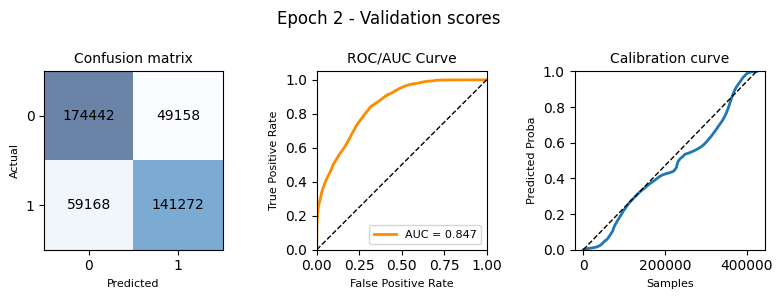

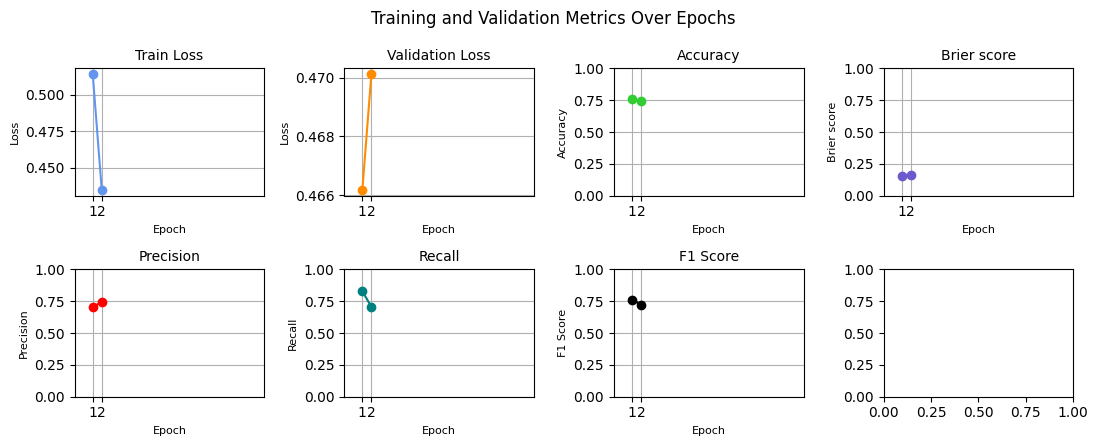

KeyboardInterrupt: 

In [112]:
# Save path
save_path = '241020_2/'
if not os.path.exists(PATH_MODELS + save_path):
    os.mkdir(PATH_MODELS + save_path)

# GNN Config
player_dims = [30, 10]
map_dims = [30, 20, 10]
player_attention_heads = None
map_attention_heads = None
dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 64,
        "input_neuron_num": 128,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.2,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 32,
        "input_neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.2,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 16,
        "input_neuron_num": 32,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.2,
    },
    {
        "dropout": 0,
        "num_of_layers": 2,
        "neuron_num": 4,
        "input_neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.1,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]

# GNN and training initialization
model = TemporalHeterogeneousGNN(
    player_dims=player_dims, 
    map_dims=map_dims, 
    dense_layers=dense_layers, 
    player_attention_heads=player_attention_heads, 
    map_attention_heads=map_attention_heads,
    player_K=2,
    map_K=3,
).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-3, weight_decay=2e-7)
loss_function = torch.nn.BCEWithLogitsLoss()

# Initialization
with torch.no_grad():
    for batch in train_loader:
        out = model(batch, len(batch), len(batch[0]))
        break

# Save the training config
with open(PATH_MODELS + save_path + 'config.txt', 'w') as file:
    file.write(
        'model: ' + str(model) + '\n' + 
        'dense_layers: ' + str(dense_layers) + '\n' +  
        'player_dims: ' + str(player_dims) + '\n' + 
        'map_dims: ' + str(map_dims) + '\n' + 
        'player_attention_heads: ' + str(player_attention_heads) + '\n' + 
        'map_attention_heads: ' + str(map_attention_heads) + '\n' + 
        'trainable_params: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)) +
        '\n' + 
        'optimizer: ' + str(optimizer) + '\n' + 
        'loss_function: ' + str(loss_function) + '\n' + 
        'batch_size: ' + str(BATCH_SIZE) + '\n' 
    )

with open(PATH_MODELS + save_path + 'gnn_code.txt', 'w') as file:
    file.write(temporal_hetero_gnn_class)



trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters:', trainable_params)

train(
    model=model, 
    optimizer=optimizer, 
    loss_function=loss_function, 
    train_loader=train_loader, 
    val_loader=val_loader,
    epochs=20, 
    trainable_params=trainable_params,
    save_path=save_path
)

---
## Round examination

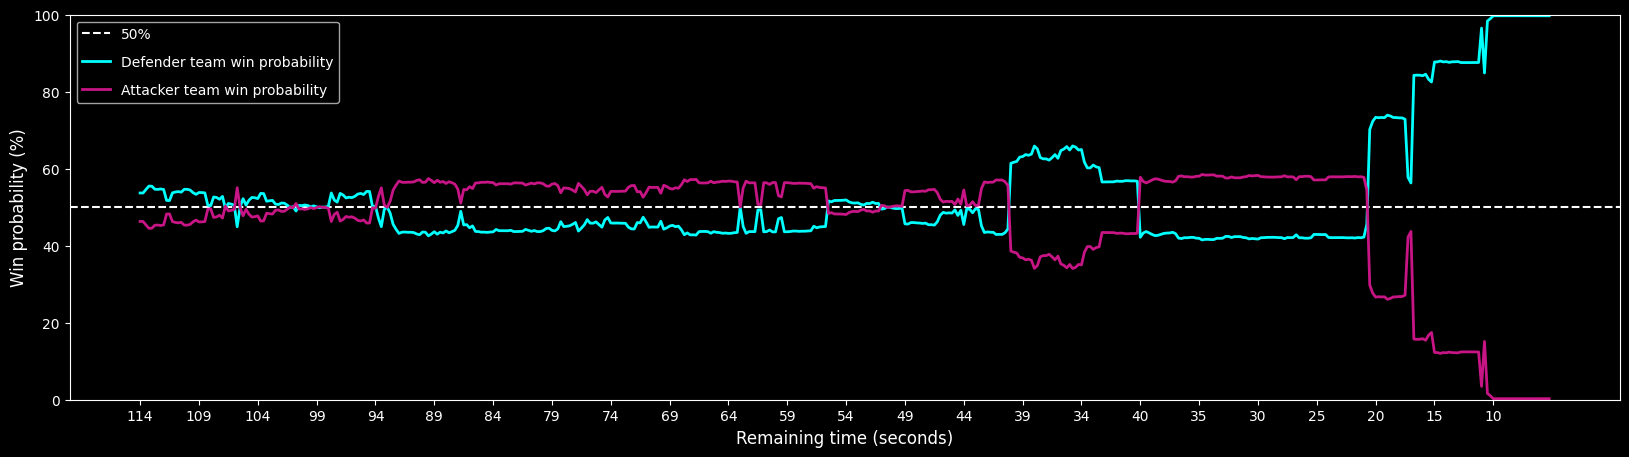

In [3]:
# Model
model = torch.load(PATH_MODELS + '/241020_2/epoch_2.pt', weights_only=False)

# Data
data  = torch.load(PATH_TEMP_GRAPH_DATA + '100000.pt', weights_only=False)

analyzer = HeteroGNNRoundAnalyzer()
analyzer.analyze_round(data, model, 7)